# Pore size distribution

Often, pore size distributions are a very important part of adsorbent characterisation. The pyGAPS framework includes several common classical methods which are applicable to mesoporous or microporous materials. A DFT-fitting method is also provided together with an internal N2/carbon applicable DFT kernel. The user can also specify their own DFT kernel.

A complete aplicability guide and info on each function parameters can be found in the [manual](../manual/characterisation.rst).

First, make sure the data is imported.

In [1]:
%run import.ipynb

Selected 0 samples
Selected 23 adsorbates
Selected 5 isotherms with nitrogen at 77K
Selected 2 room temperature calorimetry isotherms
Selected 2 isotherms for IAST calculation
Selected 3 isotherms for isosteric heat calculation


## Mesoporous pore size distribution

Let's start by analysing the mesoporous size distribution of some of our nitrogen physisorption samples.

From our available choices, the MCM-41 sample should have a very well defined, singular pore size. We can use the classical BJH model.

MCM-41


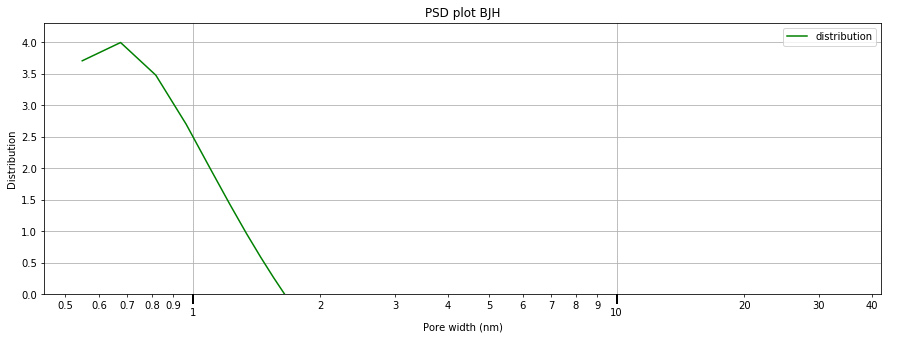

In [2]:
print(isotherms_n2_77k[0].sample_name)
result_dict = pygaps.mesopore_size_distribution(
        isotherms_n2_77k[0],
        psd_model='BJH',
        verbose=True)
plt.show()

The distribution is what we expected, a single narrow peak. The result dictionary contains the x and y points of the graph.

Depending on the sample, the distribution can be a well defined or broad, single or multimodal, or, in the case of adsorbents without mesoporoes, not relevant at all. For example, using the UiO-66 MOF, and the Dollimore-Heal model: 

UiO-66(Zr)


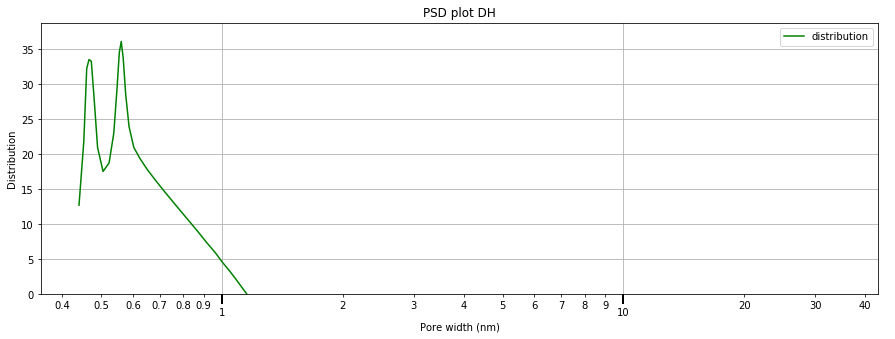

In [3]:
print(isotherms_n2_77k[4].sample_name)
result_dict = pygaps.mesopore_size_distribution(
        isotherms_n2_77k[4],
        psd_model='DH',
        verbose=True)
plt.show()

Now let's break down the available settings with the mesoporous PSD function.

- The classical models are commonly applied on the desorption branch of the isotherm. This is also the default in this code, although the user can force the adsorption branch to be used with the `branch` parameter.
- A `pore_geometry` parameter can be used to specify the known pore geometry of the pore. The Kelvin equation parameters change appropriately.
- The mesoporous PSD calculation depends on a thickness function as well, this can also be specified in the function using the `thickness_model` parameter. Either a named model or a user function is accepted.
- If the user wants to use a custom function for the Kelvin model, they can do so through the `kelvin_model` parameters. This must be a function with only relative pressure as the input.

Below we use the adsorption branch and the Halsey thickness curve to look at the carbon pores.

Takeda 5A


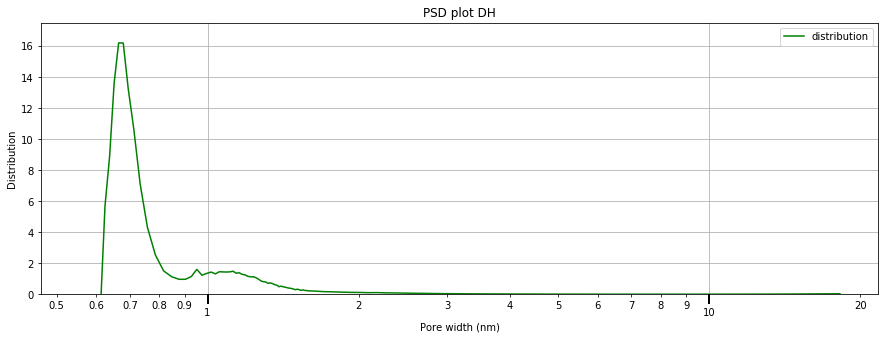

In [4]:
print(isotherms_n2_77k[3].sample_name)
result_dict_meso = pygaps.mesopore_size_distribution(
    isotherms_n2_77k[3],
    psd_model='DH',
    branch='adsorption',
    thickness_model='Halsey',
    verbose=True)
plt.show()

<div class="alert alert-info">

**Note:** If the user wants to customise the standard plots which are displayed through increasing the verbosity of any method, they are available for use in the `pygaps.graphing.calcgraph` module

</div>

## Microporous pore size distribution

For microporous samples, we can use the `micropore_size_distribution` function. Currently, the only available model is the standard Horvath-Kawazoe one.

The HK model uses a list of parameters which describe the interaction between the adsorbate and the adsorbent. These should be selected on a *per case* basis by using the `adsorbate_parameters` and `adsorbent_parameters` keywords. If they are not specified, the function assumes a carbon model for the sample surface and takes the required adsorbate properties (*magnetic susceptibility, polarizability, molecular diameter and surface density*) from the specific adsorbate in the `pygaps.ADSORBATE_LIST`. The pore geometry is also assumed to be *slit-like*.

Let's look at using the function on the carbon sample:

Takeda 5A


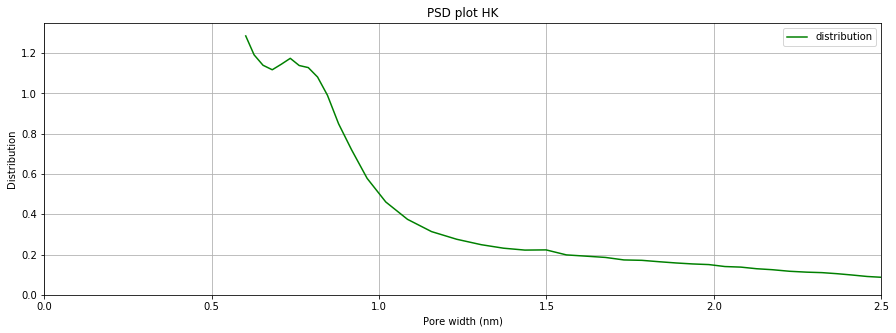

In [5]:
print(isotherms_n2_77k[3].sample_name)
result_dict_micro = pygaps.micropore_size_distribution(
    isotherms_n2_77k[3],
    psd_model='HK',
    verbose=True)
plt.show()

We see that we have a peak around 0.7 nm, but could use more adsorption data at low pressure for better resolution. It should be noted that the model breaks down with pores bigger than around 3 nm.

The framework comes with other models for the surface, like as the Saito-Foley derived oxide-ion model. Below is an attempt to use the HK method with these parameters for the UiO-66 sample and some user-specified parameters for the adsorbate interaction. We should not expect the results to be very accurate, due to the different surface properties and heterogeneity of the MOF.

UiO-66(Zr)


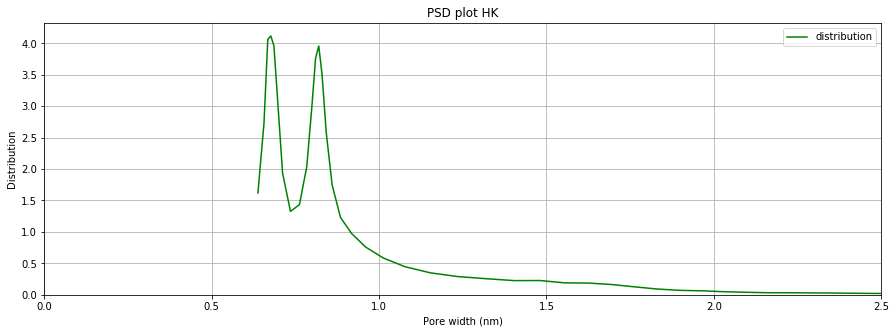

In [6]:
adsorbate_params = {
    'magnetic_susceptibility': 3.5999999999999997e-35,
    'molecular_diameter': 0.3,
    'polarizability': 1.76e-30,
    'surface_density': 6.71e+18
}


print(isotherms_n2_77k[4].sample_name)
result_dict = pygaps.micropore_size_distribution(
    isotherms_n2_77k[4],
    psd_model='HK',
    adsorbent_model='OxideIon(SF)',
    adsorbate_model=adsorbate_params,
    verbose=True)
plt.show()

A bimodal pore size distribution is seen, with peaks at around 7 and 8 angstrom. UiO-66 does indeed have two cages, a tetrahedral cage and an octahedral one, with the sizes of 8 and 11 angstrom respectively.

## DFT pore size distribution

The DFT method is the most powerful method for pore size distribution calculations. It requires a *DFT kernel*, or a collection of previously simulated adsorption isotherms which cover the entire pore range which we want to investigate. The calculation of the DFT kernel is currently not in the scope of this framework.

The user can specify their own kernel, in a CSV format, which will be used for the isotherm fitting on the `dft_size_distribution` function. Alternatively, a common DFT kernel is included with the framework, which is 
simulated with nitrogen on a carbon material and slit-like pores in the range of 0.4-10 nanometres.

Let's run the fitting of this internal kernel on the carbon sample:

Takeda 5A


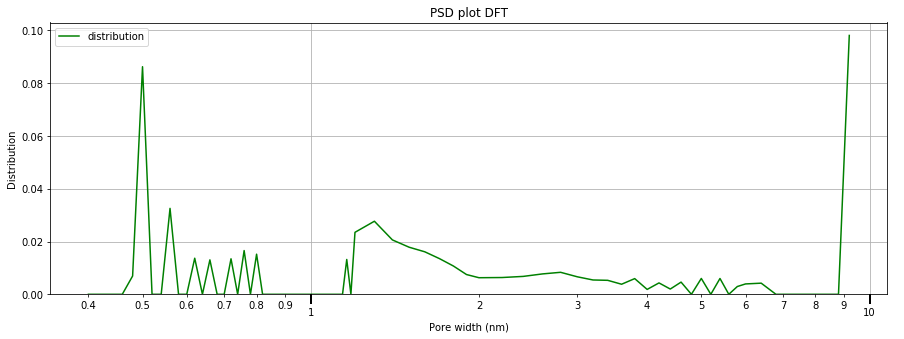

In [7]:
print(isotherms_n2_77k[3].sample_name)
result_dict_dft = pygaps.dft_size_distribution(isotherms_n2_77k[3], 'internal', verbose=True)
plt.show()

Often, we can smooth the graph to make some features clearer. Let's use a Savitzky-Golay filter.

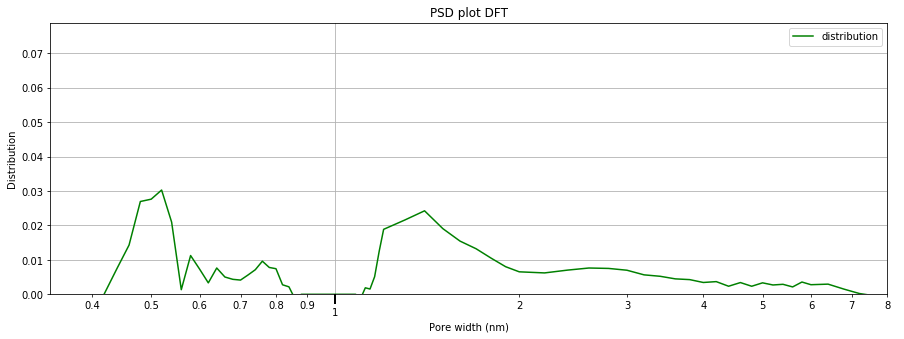

In [8]:
from scipy.signal import savgol_filter
from pygaps.graphing.calcgraph import psd_plot

pore_dist = savgol_filter(result_dict_dft['pore_distribution'], 7, 2)
ax = psd_plot(result_dict_dft['pore_widths'], pore_dist, method='DFT', xmax=8)
plt.show()


## Comparing all the PSD methods

For comparison purposes, we will compare the pore size distributions obtained through all the methods above. The sample on which all methods are applicable is the Takeda carbon.

We will first normalize the data, then use the graph returned by the plotting function to plot the remaining dictionaries. 

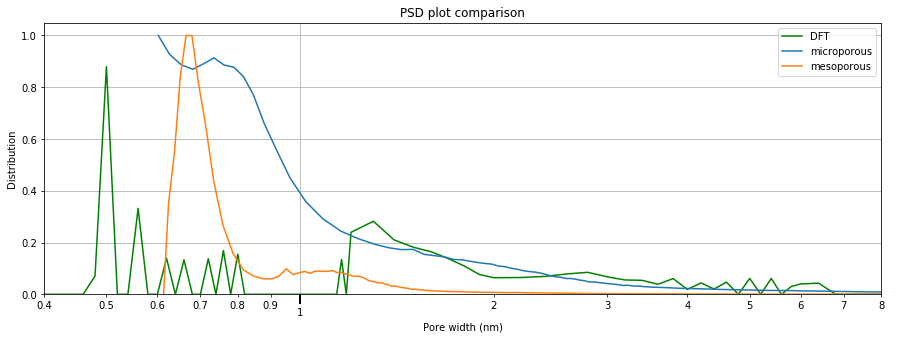

In [9]:
ax = psd_plot(result_dict_dft['pore_widths'], 
              (result_dict_dft['pore_distribution'] /max(result_dict_dft['pore_distribution'])), 
              method='comparison', label='DFT', xmax=8, xmin=0.4)

ax.plot(result_dict_micro['pore_widths'], 
        (result_dict_micro['pore_distribution'] /max(result_dict_micro['pore_distribution'])),
       label='microporous')

ax.plot(result_dict_meso['pore_widths'], 
        (result_dict_meso['pore_distribution'] /max(result_dict_meso['pore_distribution'])),
       label='mesoporous')

ax.legend(loc='best')

plt.show()

The isosteric heat calculation comes in the [next notebook](isostericheat.ipynb).